In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import logging
import galsim
import random
import cmath as cm
import math
import scipy
import scipy.stats as stats
from astropy.io import fits
from astropy.cosmology import WMAP9 as cosmo
%matplotlib inline
import tensorflow as tf
import seaborn as sns
from importlib import reload
import pandas as pd
import matplotlib
import matplotlib as mpl

In [2]:
sys.path.insert(0,'../../scripts/tools_for_VAE/')
import tools_for_VAE

from tools_for_VAE import vae_functions, model, plot, generator, results_processing, utils

from tools_for_VAE.model import build_encoder, build_decoder
from tools_for_VAE.utils import load_vae_conv, denorm, norm
from tools_for_VAE.plot import plot_rgb_lsst, plot_rgb_lsst_euclid, createCircularMask, mean_var, plot_corner_latent
from tools_for_VAE.results_processing import VAE_processing


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [59]:
former = np.load('/sps/lsst/users/barcelin/data/single/PSF_lsst_O.65/independant/galaxies_COSMOS_4_v5_test.npy', mmap_mode = 'c')
now = np.load('/sps/lsst/users/barcelin/data/single_galaxies/training/galaxies_isolated_20191022_2_images.npy', mmap_mode = 'c')

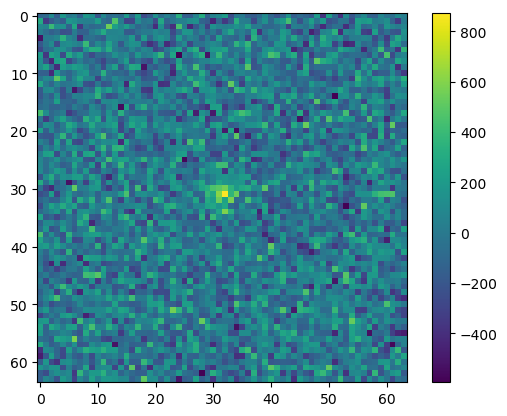

In [91]:
plt.imshow(former[0][1,6,:,:])
plt.colorbar()

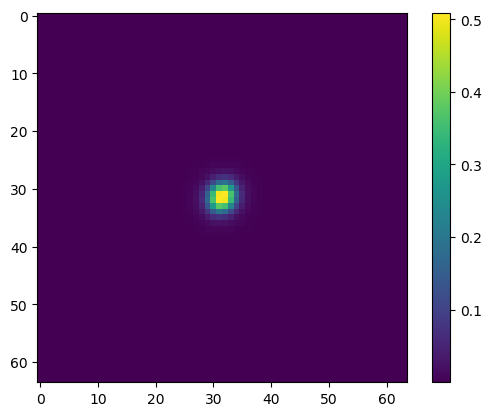

In [92]:
plt.imshow(now[0][0,6,:,:])
plt.colorbar()

In [29]:
psf = PSF = galsim.Kolmogorov(fwhm=0.65)
r_band = 6
im_size = 64
pix_scale = 0.2

N = 100

In [30]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [36]:
psf_image = psf.drawImage(nx=im_size, ny=im_size, scale=pix_scale)

ellipticities = []
redshift_R=[]
e=[]
SNR = []
scale_radius = []

flux_in = []
flux_out = []
indices = []

input_noiseless = former[:,0]
output_vae = denorm(now[:,0], np.arange(10))

for j in range(10000):
    #input_noiseless = input_vae[1]
#    input_noiseless = utils.denorm(input_vae[1], bands, channel_last = True)
#    output_vae = utils.denorm (output_vae, bands, channel_last = True)

#    for i in range (100):
    print(j)
    #try: 
    gal_image = galsim.Image(input_noiseless[j][r_band,:,:])
    gal_image.scale = pix_scale

    gal_image_out = galsim.Image(output_vae[j][r_band,:,:])
    gal_image_out.scale = pix_scale

    # Measurements of shapes
    shear_est = 'KSB'

    res = galsim.hsm.EstimateShear(gal_image, psf_image, shear_est=shear_est, strict=True)
    if shear_est != 'KSB':
        e_in = [res.corrected_e1, res.corrected_e2] 
    else:
        e_in = [res.corrected_g1, res.corrected_g2]
    #e_in = [res.corrected_e1, res.corrected_e2]
    e_beta_in = [res.observed_shape.e, res.observed_shape.beta.rad]
    print(e_beta_in)

    res_out = galsim.hsm.EstimateShear(gal_image_out, psf_image, shear_est=shear_est, strict=True)
    if shear_est != 'KSB':
        e_out = [res_out.corrected_e1, res_out.corrected_e2] 
    else:
        e_out = [res_out.corrected_g1, res_out.corrected_g2]
    #e_out = [res_out.corrected_e1, res_out.corrected_e2]
    e_beta_out = [res_out.observed_shape.e, res_out.observed_shape.beta.rad]

    ellipticities.append([e_in, e_out])
    e.append([e_beta_in, e_beta_out])

    # Measurement of fluxes
    #mask = plot.createCircularMask(im_size,im_size,None,5)
    masked_img_in_simple = input_noiseless[j][r_band,:,:]
    #masked_img_in_simple[~mask] = 0  

    masked_img_out_simple = output_vae[j][r_band,:,:]
    #masked_img_out_simple[~mask] = 0

    # Calculate the luminosity by substracting the noise
    #flux_in[j,i] = np.sum(masked_img_in_simple)
    flux_in.append(np.sum(masked_img_in_simple))
    #flux_out[j,i] = np.sum(masked_img_out_simple)
    flux_out.append(np.sum(masked_img_out_simple))

    # Save scale radius and SNR
    #scale_radius.append(input_vae[2][i])
    #SNR.append(input_vae[3][i])

    #except :
    #    print('error for galaxy '+str(j*100))
    #    pass
    #continue

    #indices.append(input_vae[3])

ellipticities = np.array(ellipticities)
e_beta = np.array(e)

flux_in = np.array(flux_in)#np.concatenate(flux_in)
flux_out = np.array(flux_out)#np.concatenate(flux_out)

0
[0.053040198730258226, 0.6287976768830655]
1
[0.054498861139159326, 1.16557063978049]
2
[0.272805356734544, 0.9357162411531785]
3
[0.038169574839950045, 0.06861221598871255]
4
[0.10241229194826189, -1.4296905921730503]
5
[0.12345699083021898, 0.524195338138399]
6
[0.44142760603288755, 1.3827333960403336]
7
[0.1157355149344705, 1.5166222112953263]
8
[0.1882489471745438, -0.3275578642070834]
9
[0.2655772561299111, 0.418988754538658]
10
[0.05821067147324063, 1.540370774028671]
11
[0.14900917868050548, -0.7892303498206134]
12
[0.10611472481925328, 0.9463210940924787]
13
[0.37172867938949217, 0.7823571607001908]
14
[0.15272130955089697, 0.9015380517687066]
15
[0.06202483372895467, -1.42952181222223]
16
[0.09299853256897032, -0.6534739142266432]
17
[0.08133587113060181, 1.3995371669459296]
18
[0.04112939039691956, -1.51639258976004]
19
[0.3049938264129897, 1.1525440284518162]
20
[0.013208039442212681, -0.6959630875363166]
21
[0.10204634522196367, -0.5832387966562812]
22
[0.0346709614094990

[0.15047228141978714, -0.9800411029941322]
188
[0.1037700882139008, 0.43061237309162287]
189
[0.2318652203575462, -0.5517220935574088]
190
[0.08469370534741563, -1.0068456553980762]
191
[0.08992887696572259, -0.17388469586844982]
192
[0.39860185332531933, 0.019758591344070407]
193
[0.3639284334933659, 0.18571600816014383]
194
[0.08310458470667453, -0.7433239727133849]
195
[0.20363460705656786, -1.2296952557806806]
196
[0.02111588976797272, 0.4874301949508757]
197
[0.0755366399984282, -1.122531181855288]
198
[0.06741155094944902, 0.7045524629154801]
199
[0.33866555267246823, -0.7748863365284129]
200
[0.06709004516042465, 1.5254792043204128]
201
[0.13991184962058675, -0.13301757075263224]
202
[0.06920694770289863, 1.0086033096143607]
203
[0.11067688343270796, -0.8153342265881781]
204
[0.3522986203835821, -1.5645308355146614]
205
[0.27580881548782216, 0.19871101830214244]
206
[0.018084708157590196, 0.8185064441840696]
207
[0.1997450794876013, 0.005602138347051686]
208
[0.09834951784057336

[0.33573604631150206, -0.05232722310822875]
370
[0.2598912824714986, -0.40744108834800874]
371
[0.17664587778137703, -0.27394823796960466]
372
[0.11757276910387834, 0.5404103982954404]
373
[0.14350790484706516, -0.7316990320337717]
374
[0.13715354464431348, -1.4898004599121182]
375
[0.22689656070674866, 1.044815975189559]
376
[0.23011446116618212, -1.2889807429746163]
377
[0.3025836233774132, -1.2448922369665698]
378
[0.08398163010285568, 0.35450520249296436]
379
[0.07135850572762087, 0.036023328427351856]
380
[0.11106921204011369, 0.5161245002322014]
381
[0.2661327916911627, -1.359657244049903]
382
[0.2518768064970379, 1.1577329092825468]
383
[0.3367665228730855, -0.015030605743508688]
384
[0.24825204532781678, -1.1369113926262262]
385
[0.06838573047137028, 1.4594102236102384]
386
[0.3205427774117101, 0.4672010985501174]
387
[0.31828988659300456, -0.05203911121675945]
388
[0.4753508890594262, 0.1572321521464069]
389
[0.4667841559415732, -0.6701642069157684]
390
[0.2707363227747151, -1

[0.30309472348366917, 0.6961418611187835]
549
[0.04811655158879353, -1.2694258856004583]
550
[0.1914286552067339, -0.52861696349407]
551
[0.18119007100152376, -0.6454155735146138]
552
[0.07081781648032195, -1.376581573687663]
553
[0.08274227708873168, -1.473976052466783]
554
[0.032770988393926795, 0.5738980912819058]
555
[0.04972678566429472, 1.4058226547500077]
556
[0.1611020950489887, -0.9780003132000948]
557
[0.37260711951473086, 1.2655138582211334]
558
[0.40758837109320484, -0.7394110646368732]
559
[0.18652773315936175, -0.5356298048454529]
560
[0.06273671051025927, -0.39468389339453985]
561
[0.3332218501686631, -0.03833805199407249]
562
[0.20742680174223238, 0.27512197219994183]
563
[0.1976402788951075, 0.2826269749425218]
564
[0.02164925430690328, 1.3158136183962619]
565
[0.674795500081534, -1.2159595943263135]
566
[0.12808768649485555, -1.0507667665038196]
567
[0.3259399568765768, 0.05984900445586954]
568
[0.1338566986908313, -0.7822154536676711]
569
[0.2051255598941531, 0.51634

791
[0.09913874748991824, -0.2110074956843146]
792
[0.14229551719936137, 0.43344046533531233]
793
[0.07140396740046505, 1.478812306662114]
794
[0.024891874488369912, 0.712718373704449]
795
[0.022224003435057472, 0.2164321428111677]
796
[0.38266226809052495, 1.0372716115777738]
797
[0.1096445807343079, 1.218055673257834]
798
[0.08829310812291552, 1.1472124928038763]
799
[0.01898455126211148, 1.053152730745213]
800
[0.43310640540895695, 0.05511977342255519]
801
[0.3394133415866391, 1.3580148844318736]
802
[0.16667064208962268, 0.9295511116878482]
803
[0.053202735142123855, 1.1449021237890005]
804
[0.44937576434303184, -0.8168860700032572]
805
[0.11162534645484401, -0.6583950350372118]
806
[0.10780635596758953, 0.12393963370276122]
807
[0.6040454091191331, -0.9992013283091001]
808
[0.3235998013422031, -0.6610115885213801]
809
[0.5481301995841785, -0.65277637151545]
810
[0.4202301034585586, -0.8683520819746224]
811
[0.0923663190627715, 1.3922145006215025]
812
[0.12428404760420765, 1.499962

1034
[0.2287623856331414, -1.5623452901895825]
1035
[0.5564578814025514, 0.5738200382214895]
1036
[0.20090142107217748, 0.2220933686001785]
1037
[0.06368375209550117, -0.8677450839936866]
1038
[0.08753696657238236, -0.7085447611486243]
1039
[0.08558863939833301, -0.28454889930976235]
1040
[0.22595800927087753, -0.9933184786569127]
1041
[0.1518168912243128, 0.5090394842125291]
1042
[0.09437589031089906, -1.3905010866425747]
1043
[0.2104252314278277, -0.7357769315998108]
1044
[0.11099214473282959, 0.6376321753461629]
1045
[0.07998034623027951, 1.366697874489016]
1046
[0.11027023731022756, -0.01136439639425176]
1047
[0.278944402933984, 1.248665989457769]
1048
[0.10773790831816729, 0.7238221477914185]
1049
[0.2736424224589838, -1.2960452575960482]
1050
[0.1514487654730741, 1.477450677119999]
1051
[0.28138636641767895, -0.6183116165872311]
1052
[0.08696748850141123, -1.41281884130129]
1053
[0.20019615797396764, 0.770574803214682]
1054
[0.2538454092081957, 0.007497281209167701]
1055
[0.29960

1225
[0.12721245076909024, -0.28544370795915075]
1226
[0.06585687300647718, -1.0700281105305613]
1227
[0.28183564783213716, -1.457161342446884]
1228
[0.13444257247516464, 1.1202967758852718]
1229
[0.25413629549288697, 1.341134113218159]
1230
[0.4701213693046279, -1.3929187913649228]
1231
[0.14237978495717452, -1.0826486026972229]
1232
[0.2392737789556506, -1.0208847625467135]
1233
[0.06659910307193592, -0.8561764239949056]
1234
[0.1805355956406088, 0.6604742551714192]
1235
[0.13994012258590777, -1.0371452852668581]
1236
[0.08535850974700426, 0.34020978061301693]
1237
[0.37730402763973636, -0.5299477879484978]
1238
[0.03439246919732252, -1.0808909721979143]
1239
[0.04420555528343373, -0.5730853659351208]
1240
[0.068752040962547, 0.5332938596273128]
1241
[0.04734533748314613, 1.3130835557889577]
1242
[0.10599723071000348, 1.4161968152988391]
1243
[0.4061382725370006, -1.3366832737189458]
1244
[0.07645192910552447, -0.35768802959872203]
1245
[0.36471797221613167, 0.073043892438096]
1246
[

[0.1306577640912298, 1.46614355354544]
1434
[0.2537548899062822, -0.4807114618537321]
1435
[0.05115600764404313, 0.7422321949757222]
1436
[0.10949229022107318, 0.3454914075077065]
1437
[0.12209414509751433, -0.756999052768376]
1438
[0.10920498919862556, 1.3408735265807639]
1439
[0.49362918059363453, -0.28480336639860093]
1440
[0.04525134882443687, -0.03704115613070767]
1441
[0.08463617401802458, -0.35618704069547813]
1442
[0.07853796139002561, -0.6035605439410399]
1443
[0.4396236764203869, 0.4163538558786459]
1444
[0.37984313348798093, 0.4402306968130688]
1445
[0.12508560090173745, 0.7087535380135536]
1446
[0.019139531175443567, 1.2834403343168794]
1447
[0.318474243212333, 1.078535054156536]
1448
[0.12291981639523819, -1.0088580044435254]
1449
[0.24303593995549794, 1.4451633910425787]
1450
[0.19112394243250272, 0.6435289239283355]
1451
[0.5037441315287194, -1.0978920211795273]
1452
[0.37723268938887733, -0.8776098796059081]
1453
[0.08293255251679846, 1.4077715692585533]
1454
[0.2058514

1661
[0.10335562925529775, 0.7210416578449375]
1662
[0.23432850293962887, -0.2858912503558728]
1663
[0.12358165791522871, 1.491235688067698]
1664
[0.35535998305661115, -1.2706731221624223]
1665
[0.16118240265371755, 0.1176368916946656]
1666
[0.11899149338686564, 0.9994941999087699]
1667
[0.06110231708817053, 0.10456975629307433]
1668
[0.042327000915443114, -1.3722987016222716]
1669
[0.21695824032471095, -0.7892276818751519]
1670
[0.40021866191163796, 0.31546775374334385]
1671
[0.003487537970840527, 0.5070992437991121]
1672
[0.37449324745567003, 1.2720289095312014]
1673
[0.5123237199942672, 0.7298775251940639]
1674
[0.2428836790288785, 0.08070146412472025]
1675
[0.11323558308366645, 0.6086933814042353]
1676
[0.08937709246694457, 1.439201956887559]
1677
[0.27025879833923894, 0.9317842650831684]
1678
[0.26193727342397055, 0.5207997462484633]
1679
[0.5634335751818609, -0.7749498881026063]
1680
[0.12541778308019008, 1.53173272491496]
1681
[0.04530288892352657, -1.055943774133792]
1682
[0.27

1845
[0.24479435811645153, 0.9771479750509385]
1846
[0.06329407009109579, 0.3833099267611642]
1847
[0.25775595169809096, 1.032846056772548]
1848
[0.6461331277917238, 0.11904462664525127]
1849
[0.15663649929337814, -0.5512260709732485]
1850
[0.49949436596743696, 0.5719968751129675]
1851
[0.10622066569092493, -1.5109825520494835]
1852
[0.24768423644206294, 1.3475841155623707]
1853
[0.2763356188869761, -1.402654019626607]
1854
[0.09954574098931672, -0.7530237588116666]
1855
[0.6588331386144775, 0.9385414861396834]
1856
[0.3855712477337477, -1.3751156880675806]
1857
[0.06397955350711539, 0.9678414718044974]
1858
[0.2584006523897817, -0.2678568171242561]
1859
[0.10266515090144618, -1.4015510832937619]
1860
[0.05492957908760341, 1.1417766290348823]
1861
[0.14882008103612593, 0.7979276855367746]
1862
[0.17330906947680802, 1.245894643299032]
1863
[0.22389385778538484, 0.9138794146702582]
1864
[0.05873493295806281, 0.06348524326405808]
1865
[0.19486402394018817, 0.961209785372876]
1866
[0.10835

[0.09917515605044405, -1.0280534557187149]
2038
[0.31826346393852806, -0.32043688088732764]
2039
[0.33324325030425417, 0.16732144421364983]
2040
[0.13561277483218614, 0.40117112632033036]
2041
[0.13969297551045118, 1.0847751324693375]
2042
[0.22913837084919703, -0.023764791397540064]
2043
[0.07566985575864124, -1.1179315252386839]
2044
[0.04193960301674565, -0.48477110513147076]
2045
[0.05127770873010802, 0.7040864631717949]
2046
[0.11474598608032509, -1.4590795602855582]
2047
[0.2441766935008895, 0.2311358619050452]
2048
[0.3897184318887144, -0.5249904539320321]
2049
[0.12026480652174967, -0.192032349911733]
2050
[0.04754194056677547, 0.9204987079039672]
2051
[0.20933464359073423, -0.4063935849665797]
2052
[0.5341011108906463, 1.2046473046669555]
2053
[0.5842271384837742, 0.38465246530769454]
2054
[0.07313634356918403, -1.3282630263859394]
2055
[0.04220838216457998, 1.436392993520362]
2056
[0.23803887306571528, -1.2815009604050756]
2057
[0.06476770453641241, 1.5538266484811776]
2058
[

[0.21800522566934014, -0.38277552609828097]
2234
[0.142910024542312, 0.18128935618277447]
2235
[0.01589764434435718, 1.4346071838729275]
2236
[0.31631264727451336, -0.21437317843255815]
2237
[0.3032313759478874, -1.0717052312039728]
2238
[0.21040712482348403, 1.5058368979705004]
2239
[0.15076901530290232, 0.2997621741928228]
2240
[0.3338876933296643, 1.3802150113011047]
2241
[0.07964272680033191, -0.6129630541465821]
2242
[0.46922027057701526, -0.638508839301036]
2243
[0.1694140725384785, -0.0025161246214589995]
2244
[0.1532493603618337, 0.08262527184477969]
2245
[0.10639123345001415, 0.5953665509949434]
2246
[0.07741711136999684, 0.29296430261975603]
2247
[0.5278085992060331, -1.2002981907231782]
2248
[0.0270110222878627, 0.8852562725986747]
2249
[0.41481875605475604, 0.48405710134199087]
2250
[0.12040426592080462, 1.2926118089946337]
2251
[0.04168254008955353, 0.17301216175893144]
2252
[0.45053855883114746, -0.8099820410784855]
2253
[0.41545636351660215, 1.2386802860237187]
2254
[0.1

2420
[0.009367696809393623, -0.34249214940728245]
2421
[0.36341001753818514, 0.6563795759087707]
2422
[0.2519727572320091, 0.8367967664295013]
2423
[0.18114376906888072, 0.04293773794887148]
2424
[0.22770675752499286, -1.1040597143136748]
2425
[0.1340488871683168, 1.4794069186555534]
2426
[0.6854768809110562, 1.4983136361803122]
2427
[0.21087007143928632, 1.4584747818735817]
2428
[0.06112255077767809, 1.568053940980814]
2429
[0.2936515066729229, -0.5803763539055603]
2430
[0.23542087993178584, -0.6045848331990679]
2431
[0.06725136366536387, -1.4090567267523537]
2432
[0.018979685346374207, 0.8432274448678058]
2433
[0.1111471586411375, 1.3032114808796995]
2434
[0.39887588774024557, -0.5342769605323875]
2435
[0.0563821856495439, -0.3223935551902735]
2436
[0.6510905715645564, -1.4671978505910075]
2437
[0.27024080043153026, 1.4456307600218745]
2438
[0.18034393384160113, 0.3864627994934777]
2439
[0.09853774162063816, -0.00368304915189803]
2440
[0.20658188733371968, 0.0550424607072109]
2441
[0

2617
[0.6009039202549732, -1.3224300011310006]
2618
[0.15875976181602355, 1.1904957300411156]
2619
[0.507736314799965, 0.37915827372819033]
2620
[0.18265990922642272, -0.17663599843452651]
2621
[0.009373231529859924, 0.43584882708816075]
2622
[0.12224461214383704, 0.577741225590073]
2623
[0.12672498252731848, -0.27107142594147177]
2624
[0.26754264304085373, 1.0991207063932351]
2625
[0.39735936062038874, 0.06586242667424255]
2626
[0.2882692856554731, -1.4836517264631934]
2627
[0.13517949555826747, -0.4565955711131478]
2628
[0.48325393978757425, 1.5372407326045867]
2629
[0.18054575945149545, -0.42372333958021635]
2630
[0.3925271685686842, 0.7482105185263644]
2631
[0.0869850407179797, 0.05094999277564521]
2632
[0.3212013061490408, 0.395733789019419]
2633
[0.08514987704391101, 0.9507859281705991]
2634
[0.07748843414696574, 0.029929053891070735]
2635
[0.25393113433427855, -0.4300009075749235]
2636
[0.08101363273054966, 1.4842287242069148]
2637
[0.07350348467944355, 0.6860155849504308]
2638


2807
[0.13758895001818292, 0.659551530000212]
2808
[0.35834629995368866, -0.7361421354571559]
2809
[0.24825271691390075, 0.09974480777503025]
2810
[0.10669235624445336, 0.08276072541592806]
2811
[0.04518849044214599, -0.45476354838120336]
2812
[0.09167304512060341, 0.7067352197657601]
2813
[0.10879360866189786, -0.5958416077043198]
2814
[0.11583484671422267, -1.0284979079674874]
2815
[0.36338897142703963, -0.4412202059052542]
2816
[0.1357099975649252, 0.5098977207464613]
2817
[0.1849326662001381, -0.0138429823505423]
2818
[0.11732360699090709, 1.5447859751595219]
2819
[0.5088084609363058, 0.8826760295144808]
2820
[0.5385604903483054, 1.1552755295230324]
2821
[0.08102522657572413, -1.1468275550806069]
2822
[0.08428027351494494, 0.8998897695509912]
2823
[0.14899162073179542, 0.7658106374414205]
2824
[0.15922220426698913, -0.7762376467049829]
2825
[0.0588118001770712, 0.7245480102678775]
2826
[0.3716492351506439, -1.4022414595739097]
2827
[0.3616679300210288, -0.46521022562496767]
2828
[0

2987
[0.26068791449103235, 1.05235197036636]
2988
[0.13328715712202918, -1.5140995212737056]
2989
[0.34774958083954577, -1.0140915012448974]
2990
[0.09149142689043399, -0.2766918644183312]
2991
[0.17613684937399107, -1.3758126676048945]
2992
[0.36626313740057664, -0.3785298793259948]
2993
[0.07074723773184552, 0.04312650770179286]
2994
[0.05372719055934122, 1.0040055915159047]
2995
[0.14959720622185255, -0.7810963328817178]
2996
[0.12725644678247605, 1.0399160011158042]
2997
[0.18534457112107502, -0.7424748622214038]
2998
[0.22508969681575558, 0.7561013244509566]
2999
[0.1558948524790206, -1.2165568008000553]
3000
[0.11078667764947608, -0.41919271534359165]
3001
[0.20153606437621985, -0.43618061750942105]
3002
[0.302584661602251, 0.3480375828096241]
3003
[0.2635062613947971, 0.17729236772411408]
3004
[0.43816889450332563, -0.3396445864485226]
3005
[0.06717301810011617, -0.6676563234044823]
3006
[0.43957067521722387, -0.30852937145436465]
3007
[0.4325078961164503, 0.5688429803554382]
30

[0.5819361354188495, 1.0851005418793398]
3179
[0.23556779861937432, 1.2407467453543068]
3180
[0.1654752682543905, -0.11495384479797557]
3181
[0.35431540324243344, -1.0446029509473658]
3182
[0.09567453166121496, 1.1809904797957627]
3183
[0.4439667126866095, -0.5465770343226244]
3184
[0.03578912387111607, 0.019046953288266905]
3185
[0.32028930704432185, 0.7816387954465372]
3186
[0.1337392186772524, -1.433709931513486]
3187
[0.23678600495944588, 0.07616909397761527]
3188
[0.2512345174385635, 0.31008364967372215]
3189
[0.2079296567529525, -0.9540362985643969]
3190
[0.23605093620771825, 0.8748280348657383]
3191
[0.30608205990013954, -0.2777373197960686]
3192
[0.20523295870743988, 0.5660960372170236]
3193
[0.20693396185382026, -0.9153467914018409]
3194
[0.376867520075303, 1.5160508536217598]
3195
[0.17239084253843728, -0.9712262973035525]
3196
[0.20375100448633332, -1.0138615524101802]
3197
[0.12506178305781104, -0.4745925662425298]
3198
[0.33069024779662815, -0.3564534742188308]
3199
[0.159

3364
[0.05048864915044354, 0.9089611315435282]
3365
[0.1498390809422794, -0.24011223146834734]
3366
[0.5393447473950991, -0.16983875294812362]
3367
[0.13089459672925258, -0.2088845360054394]
3368
[0.05270169115780854, -0.6694985859655783]
3369
[0.4274701572993077, -0.5562769186956154]
3370
[0.15637063813292532, 0.41719103152083864]
3371
[0.2812695556779687, 0.9814783172850196]
3372
[0.24821253992859552, -0.7151011060636291]
3373
[0.07770986211533094, 1.222523997765555]
3374
[0.11458912660043918, 0.8729896178434454]
3375
[0.10365952162825004, -1.1984958960052332]
3376
[0.1362513303764799, 1.2490474949009864]
3377
[0.3191512746210316, -0.14164674036423378]
3378
[0.061358614251874985, -0.6888967868376175]
3379
[0.1298104991450493, -0.05044829584556736]
3380
[0.24883573896839314, -1.0352467163135257]
3381
[0.3184729064129369, 0.21917322879503207]
3382
[0.35142729201494566, -0.6438719230294738]
3383
[0.3083945951757804, 0.15502486436763865]
3384
[0.04781549804777325, 1.5112581629312958]
338

[0.12455137406652195, 0.24312946287238207]
3569
[0.2624770763312252, -0.8114259618099332]
3570
[0.07616291562322831, -0.2088313207280119]
3571
[0.11778376917756787, 1.235325230297558]
3572
[0.24907035444565864, 0.47801083846814807]
3573
[0.001984958005672114, -0.5625164272153724]
3574
[0.11816231931323146, 0.155591224784882]
3575
[0.15158145985114055, -0.8485061662297756]
3576
[0.27259696087821356, -0.5845592713984915]
3577
[0.4098980903214075, 1.4652929962932248]
3578
[0.30489192539170906, -0.6198547151791212]
3579
[0.17680656763503746, -1.5617571334731413]
3580
[0.2352949087130241, -0.011670375311155305]
3581
[0.026258258725561572, -0.38485837593487243]
3582
[0.1965149543600561, 1.4987484279736731]
3583
[0.1350984954406145, -1.5184726650214986]
3584
[0.23913751965865868, -0.9679830819701967]
3585
[0.08506898558113218, 0.49530206613752337]
3586
[0.12193264881678414, -1.002893205815277]
3587
[0.03706662912077822, 0.5542237403517127]
3588
[0.13840825952536434, 0.7840843624804472]
3589
[

[0.10250247780284108, 0.7529127807167133]
3778
[0.30960951464020087, -1.3419106366095257]
3779
[0.26289157011348785, -1.3257398354209473]
3780
[0.13273091946622834, -0.6171948792040964]
3781
[0.13200838062021603, 0.8486278085607186]
3782
[0.3982549397660464, -0.42198081773221635]
3783
[0.102162145136459, 0.35859672766690426]
3784
[0.15344021744604677, 0.5117963757323287]
3785
[0.1171486861694036, 0.804758477983426]
3786
[0.34358719973038077, 1.5040337546213964]
3787
[0.25096609300066325, 0.017112841876312505]
3788
[0.0810171688610466, -0.07505927127922093]
3789
[0.5057197089490965, -0.8830636064992056]
3790
[0.149123035911763, -0.9638546108217405]
3791
[0.2823540999465744, 0.09182608778834907]
3792
[0.0954415331240934, 0.8340135258172414]
3793
[0.15904678751272483, -0.6564318382085933]
3794
[0.15709543533083486, 0.38075380592781904]
3795
[0.036749932678488, 0.47545633248977104]
3796
[0.06082394876923165, 1.2963344439569817]
3797
[0.2364501657988456, 0.8285134474672557]
3798
[0.25802411

3971
[0.06291947229658869, 0.6426419042833574]
3972
[0.07113432279231315, 1.3498015499029208]
3973
[0.36247614422151525, 0.09006246364409966]
3974
[0.2663952822696744, -0.9529887322082456]
3975
[0.3703743108045851, -0.7111558078835419]
3976
[0.3285040873250971, -0.09905296214670951]
3977
[0.10016414069825935, -0.8137986569206735]
3978
[0.12359457305376145, 1.4100834089713847]
3979
[0.02688392058643021, 1.0185366970333856]
3980
[0.42908241535165353, 0.8451563840082146]
3981
[0.0748898048605566, -1.1646718939724494]
3982
[0.30046478781270924, -0.5515997815452124]
3983
[0.29869651285228493, -1.2136191267528267]
3984
[0.43380033556214265, 1.4429133773136167]
3985
[0.35254434766679726, -1.196087123488559]
3986
[0.46544080034257307, 0.3783937445832988]
3987
[0.4250708307198572, -0.3582268835368588]
3988
[0.18665584319360445, 0.09066742284431326]
3989
[0.017392337515912175, 0.32530021340892745]
3990
[0.1954348792108351, 0.0593265317386198]
3991
[0.29694030627155965, -0.45837770269300426]
3992

4186
[0.37163749511069616, 0.9411254116419373]
4187
[0.08030607859991015, 1.2412347384883933]
4188
[0.26438089717814806, 0.05830920253276472]
4189
[0.3650851154077793, 0.6302296360618774]
4190
[0.16869983606938366, -0.8946159197920924]
4191
[0.3343996595570395, -0.33455521047722425]
4192
[0.30914410856674085, 0.5547639873203049]
4193
[0.20963590873399737, -1.5481374465080546]
4194
[0.07758473170490791, -1.305232719784178]
4195
[0.037315467192153756, -0.8256979838209215]
4196
[0.005309578579474875, -1.3496693963797433]
4197
[0.0009405116139883787, -1.2003214781702136]
4198
[0.6671630897711381, 0.5668402700576931]
4199
[0.10590725755420044, -0.15619698560547135]
4200
[0.21367351809396384, 1.4309072867081507]
4201
[0.04066502222439836, 1.1796672434838673]
4202
[0.19790639845914834, 0.752597144129231]
4203
[0.191351615334813, -0.8255003481377894]
4204
[0.21201233857761412, -0.2434259148037723]
4205
[0.00535213540170918, 1.4097745480292687]
4206
[0.08045746310315964, -1.1597560425733235]
42

4396
[0.14281577041060528, -0.8688741498262903]
4397
[0.1839129637059929, -1.358366469883269]
4398
[0.07764081528981134, -0.9435286590734213]
4399
[0.008955795859837462, -0.0484191704388296]
4400
[0.2946915970255867, -0.7853101008252549]
4401
[0.05068902263412801, 0.9588889071935893]
4402
[0.20477695426982187, -0.7754101848585674]
4403
[0.02802248224686405, 0.5211895407579709]
4404
[0.04847062755338884, 1.03071358302552]
4405
[0.0808321604716175, 0.37821288498854455]
4406
[0.2142922894427945, -0.13395804514856935]
4407
[0.06274352925825202, -1.3108130678919252]
4408
[0.3397399321531809, -1.2260973271663622]
4409
[0.4370539025221532, -0.22279703814400056]
4410
[0.05728136692868804, -0.5057300724344787]
4411
[0.20211458769161755, 0.4447390591523517]
4412
[0.29970075566877274, 1.5094392660149651]
4413
[0.14297672405483688, -0.34877642725415137]
4414
[0.11938754884211582, 0.8864393006230294]
4415
[0.11113749480551595, -0.9642477962278471]
4416
[0.062304461818356825, 0.1581151074364596]
441

[0.1289835180909792, -1.281460325898169]
4634
[0.5915396509127264, 1.0104177216624133]
4635
[0.09506851708158019, 0.7116491593321344]
4636
[0.14911652333328845, 0.3713982614569029]
4637
[0.35296350754845396, -0.037364425103786354]
4638
[0.23390634712201874, -1.4795714772034403]
4639
[0.18439536927817066, 0.03137625200543347]
4640
[0.416023202174497, 0.16679481110753086]
4641
[0.37842758793463505, 0.9550277198697057]
4642
[0.07837866204091833, -0.7975426371126969]
4643
[0.5070730211585367, -1.0147243549026657]
4644
[0.14364021573311386, 0.9802398696001874]
4645
[0.2398621077267677, -0.16143747152175006]
4646
[0.1381019058710696, -0.06448307621659226]
4647
[0.1871539060786894, -0.9892920199943774]
4648
[0.05355956849952414, -0.4347249997352423]
4649
[0.4263105412939804, 0.945253939398845]
4650
[0.18043658701872087, -0.3213715437045083]
4651
[0.1671739071688824, 0.48881200136891906]
4652
[0.0995952842228864, 0.5779436080631252]
4653
[0.20195910689013075, 0.9499470551705058]
4654
[0.162908

4819
[0.2901886585550208, -0.7985662563439545]
4820
[0.19714922567491222, 0.014273476171132624]
4821
[0.2889219657395347, -0.9697540439806478]
4822
[0.28362941499609234, -0.3449410047620164]
4823
[0.4307252964041683, -0.952168267875188]
4824
[0.355386025241213, -0.9357705636121161]
4825
[0.11216364108677311, -1.2314834081647967]
4826
[0.052163176759275794, -1.300322922202237]
4827
[0.2584469181436118, 0.6560127264318629]
4828
[0.07471583080625434, -0.8286122131237925]
4829
[0.28017327770307227, -0.20718913340534284]
4830
[0.11802367569116759, 0.8925911377002915]
4831
[0.22465772117729788, 0.8744303951214255]
4832
[0.6310732869516213, 0.796694165620067]
4833
[0.10141964451304299, -1.0225996974829592]
4834
[0.10631296614724736, -0.34922021045576546]
4835
[0.2057686928985618, 0.19979116672350125]
4836
[0.18895092851975615, -0.9832243646518618]
4837
[0.3501731873829776, 1.246952158784973]
4838
[0.11314075335980578, 0.08743166497202973]
4839
[0.11678926861880765, -1.4396875138502683]
4840
[

5010
[0.17035938214332813, -1.0731709548414907]
5011
[0.039333272006991764, -1.295467795810421]
5012
[0.24122002550829677, -1.1854045583652744]
5013
[0.31002076205084217, 1.2282779956948067]
5014
[0.09282025359580219, 0.9386930081097898]
5015
[0.10384366328398574, -1.527060500242595]
5016
[0.313023111671983, 0.4792310541393701]
5017
[0.2110630015433791, -0.19461173643450655]
5018
[0.2177924929767799, 0.12278030848217239]
5019
[0.16199553847056194, -0.18960267056297883]
5020
[0.34798307180804045, -1.2260374912401206]
5021
[0.4169352451786172, 0.017841192029324594]
5022
[0.0729260167283501, 1.136318683556335]
5023
[0.2769564021006281, -1.5310864397242385]
5024
[0.14350066986801707, 1.1475483901415269]
5025
[0.5743211534003392, -0.07076088697979084]
5026
[0.20109822085660392, -0.9639308058528362]
5027
[0.5911336350153525, 0.5188921308199539]
5028
[0.14472058349285707, -0.008586180655055259]
5029
[0.2569460280669066, -0.01446568835052954]
5030
[0.46399485373543997, 0.41217393083478315]
503

5208
[0.5836622200032197, -1.3716565974489696]
5209
[0.05824652838121632, -0.44207936941923287]
5210
[0.38237354072477836, -1.2584767381899118]
5211
[0.28448808362997596, -0.9517467842879095]
5212
[0.3129164150912253, 1.0859583973378795]
5213
[0.2900800887511269, -0.9190806824487627]
5214
[0.5389614558150143, -0.3343954823622183]
5215
[0.3757813802237352, 1.4442483632490377]
5216
[0.06097761357952818, 1.0107009036368928]
5217
[0.006343311919023556, -0.23589993972769888]
5218
[0.15814830504308458, 1.0786440084007396]
5219
[0.2968685582161307, -1.5063314163040222]
5220
[0.008585129994939081, -0.019595168303917224]
5221
[0.4440144405910091, -1.4874781309683514]
5222
[0.10312267153377777, -1.1544299282260408]
5223
[0.02143141031368798, 0.3924241735778272]
5224
[0.14892851612343566, 0.6296099705225384]
5225
[0.12113219165561386, 0.2523459500514261]
5226
[0.2551892832139627, 0.9738963173101284]
5227
[0.12145219398029032, 1.0057554927403796]
5228
[0.29188509642077504, 1.3809150986560417]
5229

5440
[0.09426357352664415, 0.03520019123890635]
5441
[0.07527945354162596, 0.10292862040052729]
5442
[0.17593562966744075, -1.2829189207102654]
5443
[0.08157022687632723, -0.8049127939451056]
5444
[0.2957127744727415, 1.0639340167346902]
5445
[0.016787501572696234, 0.3115857598267618]
5446
[0.13396732960727406, 1.184912163509558]
5447
[0.11925627927795973, 1.3437978488580773]
5448
[0.030945345111315296, 0.25591330427052933]
5449
[0.3967337241618232, -0.3519385300013631]
5450
[0.2316168083145433, 1.002481358843613]
5451
[0.04744304450200287, 1.0540098925609844]
5452
[0.16849015307587914, 0.13486858262682092]
5453
[0.3428222572618007, -1.0625848786878898]
5454
[0.0890669489887015, 0.41930944082503613]
5455
[0.24169345286409633, -0.29079763620517834]
5456
[0.23358778111117667, -0.9337599059081559]
5457
[0.050569290094494325, -0.04593391459291903]
5458
[0.12083592455356362, -1.245186716169221]
5459
[0.14452461626225954, 0.19488384049551824]
5460
[0.21521918472662302, 0.21730245448902055]
5

5627
[0.06701112316981139, 0.18677059109613534]
5628
[0.22421991259610466, 0.7347770684568853]
5629
[0.08299448949032752, -0.8927261886611207]
5630
[0.2572461123440918, -0.45733243338859253]
5631
[0.0310420659018876, 0.3469616815448937]
5632
[0.10204614190457864, -1.338892394519131]
5633
[0.2944996737350369, 1.4918183849806552]
5634
[0.143624944164809, 1.0216548127017424]
5635
[0.3176014665236471, -0.7020144742371769]
5636
[0.45713347390509834, -1.174300351579166]
5637
[0.017080758229854547, -0.5241821286613583]
5638
[0.33378226410358564, -1.0324989168514518]
5639
[0.19252613669046623, 1.5051880116097325]
5640
[0.16831990630622026, -1.0408696720525006]
5641
[0.2892202217768531, 1.101932179998713]
5642
[0.20939443427375246, -0.10121537691001653]
5643
[0.5882363477025835, 1.3123212906618311]
5644
[0.23051803214655747, -1.567402947707936]
5645
[0.2018874876490929, -0.07955973916649657]
5646
[0.41196511973437244, -0.4407070184511184]
5647
[0.3623082592623425, -0.48635059021403204]
5648
[0.

[0.042866481682907166, -0.5910953974455216]
5813
[0.3970382871796803, -1.1688364226281225]
5814
[0.09160932889241895, -0.8937867735172484]
5815
[0.08564090364004291, 0.8934505340755794]
5816
[0.16409080054678712, -0.6950370132284235]
5817
[0.3554969322968987, 0.5591972189356216]
5818
[0.08606667472317332, 1.218836619625786]
5819
[0.41169128869360216, 1.1520300573924471]
5820
[0.26261479483999184, -0.7954743554585578]
5821
[0.777359427703132, 1.223207354164419]
5822
[0.05398455571720725, -0.42469189966066667]
5823
[0.10997126210100286, 0.8030171308612123]
5824
[0.15442316360692446, 0.43439045186158476]
5825
[0.004759876711542226, 0.6716125136520494]
5826
[0.561135921186605, 0.10301982553085148]
5827
[0.261692478063492, -0.030853435805793524]
5828
[0.43891341601326533, -0.02943348786065976]
5829
[0.22595552769232757, -0.9024304537800925]
5830
[0.13929186329736515, -0.8441314827432042]
5831
[0.03859547065275466, 1.2483052017480913]
5832
[0.01620335563754802, -0.5727598600804142]
5833
[0.0

5996
[0.07620796143738762, 0.8771346321566087]
5997
[0.2948633370299425, 1.4891920455984995]
5998
[0.28065552938082855, 1.2148067123065678]
5999
[0.10826122267729776, 0.8659628043078288]
6000
[0.08934178545246306, -0.8437167552274909]
6001
[0.23326695549084392, 0.5265969661223616]
6002
[0.25058851724878334, 0.8182622880565691]
6003
[0.16459029928253402, -1.2746418420381302]
6004
[0.12454178329569243, -1.3465179410500585]
6005
[0.0668931333356689, -1.536743362904258]
6006
[0.026682126847617973, 1.2786018303113889]
6007
[0.14221403388050166, 0.05507217344637398]
6008
[0.1322385248143389, 0.19071245849948834]
6009
[0.03994627348634995, 0.5367446958533576]
6010
[0.22295131789597605, -0.041839470112752096]
6011
[0.04024691830686687, -0.2887861860975559]
6012
[0.14019488647007297, -1.3336362597723814]
6013
[0.1292457723401137, -0.8107569504819285]
6014
[0.4022447282794263, -0.3844375794672426]
6015
[0.3122953668759981, -0.6540543517429908]
6016
[0.7712246795516444, 0.34163251805118006]
6017


6191
[0.016479763341235614, 0.8730031184942065]
6192
[0.07210133184572595, 0.7903518937142181]
6193
[0.31177565910379246, -0.14156244147336955]
6194
[0.16302086222211087, -1.2280163138492886]
6195
[0.23093840654132766, -1.5467031583913282]
6196
[0.4358680492591673, -1.0654144627909228]
6197
[0.08329054518212106, -1.1798370629459944]
6198
[0.1436090078091591, -1.5353121154335556]
6199
[0.0074583710623408375, 0.6952200118014218]
6200
[0.09337561731441682, 1.4663275800293925]
6201
[0.020609747033758733, -0.17961317602465227]
6202
[0.01875013552324034, 0.39241861399555705]
6203
[0.12806605282281733, 0.7646067542581261]
6204
[0.04095291461873903, 1.465522324152799]
6205
[0.1846692187623227, -0.7034598624483123]
6206
[0.029691418412841425, 0.9666016043868754]
6207
[0.24185419204324768, -0.13492056743990755]
6208
[0.45042455125001035, -0.2239667789627462]
6209
[0.3223993492787846, -0.9664992243863445]
6210
[0.17140971475215983, -1.017791311337245]
6211
[0.23797618924272426, -0.060410091373397

[0.3690732950387396, 1.2752893389855726]
6393
[0.2271842139311563, 0.9260782976528431]
6394
[0.2055103078536997, 0.8298336130734667]
6395
[0.29605918861367364, -1.0586178152924028]
6396
[0.2980374828196674, 0.8324481337101496]
6397
[0.18337912141715546, -1.5483284776110593]
6398
[0.24525807395523305, 0.20882219194870924]
6399
[0.3200964411065114, -0.33605047818106387]
6400
[0.4149901003026301, 0.0711466120646486]
6401
[0.07926723299871227, 0.4916967857424649]
6402
[0.44106285219327407, -0.8628834495340024]
6403
[0.13884352402640063, 0.9432326211763209]
6404
[0.1926093404748807, -0.07566858234441823]
6405
[0.032950377457190275, -1.1252124100169487]
6406
[0.197672109706649, -1.5405104940792784]
6407
[0.23986362701688868, -0.08643438627124635]
6408
[0.09070388119658933, 1.3195091686843228]
6409
[0.010233719814204274, -0.6556404240940714]
6410
[0.25176222577792856, -0.9893279019259624]
6411
[0.1623058230267636, 0.25218299623362445]
6412
[0.2627004777630657, -0.3130754582651377]
6413
[0.048

[0.11342060864049358, 0.17217335735998723]
6592
[0.10835489328546041, -0.7698990822609926]
6593
[0.12843059086522152, -1.029926416503182]
6594
[0.18856236621038694, 0.776961855776387]
6595
[0.09699351128520985, -1.2458953508423785]
6596
[0.35150395176011323, 0.7371379075179322]
6597
[0.06267091406513255, 0.8846708182151367]
6598
[0.29781209450837937, -1.2614840710427204]
6599
[0.08195277017911941, -1.3396397946209324]
6600
[0.16032505062613853, -0.06461582229507333]
6601
[0.13204931327414252, -0.5136762097608921]
6602
[0.2800842873099103, 1.1031061412578356]
6603
[0.21516096649686628, 1.1848401363049497]
6604
[0.4173068099451432, -1.5632732073058933]
6605
[0.0855229464685004, 0.3998290232643141]
6606
[0.14897001321859382, 1.5126980895672086]
6607
[0.33202737836742086, -0.198440299271855]
6608
[0.21751133859077562, -1.056852512534324]
6609
[0.35968767532323065, 0.6345980042691131]
6610
[0.07321048853699522, 1.4372638923036427]
6611
[0.10937516159595925, -0.06775220224298595]
6612
[0.202

6780
[0.0604248654980888, -0.5749177561334379]
6781
[0.290188921681429, -1.044541741198126]
6782
[0.12110407070430092, -1.1295314166890882]
6783
[0.2884517778830712, 0.10649019188620513]
6784
[0.07371177547487519, -0.7097604860385407]
6785
[0.34936692910552225, 0.14739722108334594]
6786
[0.1741383790937127, -1.1261229754686846]
6787
[0.29143408446127134, -0.022161815995953106]
6788
[0.11206064644634176, -0.7346188968695904]
6789
[0.07783052552729394, 0.1155427765322729]
6790
[0.21952870308742473, 0.4543185381774052]
6791
[0.20675741604644493, -1.5096181294846096]
6792
[0.20444661280616244, 0.49678305630074865]
6793
[0.11412483482434076, 0.63562163391628]
6794
[0.0344177487589922, -0.9817739131925378]
6795
[0.36960041415683287, -1.362868431755151]
6796
[0.574392120774667, 0.6255890116312098]
6797
[0.3425255155796098, -0.7853256759461479]
6798
[0.07323074501443717, 0.5607946907590213]
6799
[0.47348542959042283, 0.7768742098999858]
6800
[0.5134231437360455, 0.25577853865996175]
6801
[0.09

6973
[0.3512749402009375, 1.4711661348506888]
6974
[0.06943617081350234, 0.644609472580921]
6975
[0.07214360220769621, 0.21560371453316876]
6976
[0.051837701113776835, -1.4298433868274465]
6977
[0.38982193410253163, -0.948504236908834]
6978
[0.19186300920676208, 1.184191881685904]
6979
[0.034876199671551096, 1.3746767560214073]
6980
[0.31590570009567404, -0.6118884199805856]
6981
[0.11859949728927663, -0.9235301204666917]
6982
[0.07506848189865373, 1.0994772800735515]
6983
[0.18469489757819893, -0.8338071788045476]
6984
[0.14647485097129426, -1.5351429654141637]
6985
[0.27966402798767753, -1.4682700073999289]
6986
[0.04754546826318298, 1.3174847707807371]
6987
[0.5005839041535698, 1.331400985803905]
6988
[0.0371973823633909, -0.2957300532335044]
6989
[0.2995239222451092, 1.5011622185804245]
6990
[0.029575163237869878, -0.030684325630823326]
6991
[0.014922404697688465, 0.3863301730131928]
6992
[0.3699579292283737, 1.0687880076763085]
6993
[0.18968809572879594, 1.131962589309827]
6994
[0

[0.1646591882241204, 0.11659724131131624]
7207
[0.057173929904068777, 1.305551085094847]
7208
[0.13202010412627455, -0.06280288470838563]
7209
[0.1576032010922437, 1.0387644644656955]
7210
[0.01189798774837452, 0.3627899772099334]
7211
[0.4002519717275519, -0.19267566881790252]
7212
[0.15074644745081972, -1.294685709233356]
7213
[0.1442738982201792, 0.6435283860535636]
7214
[0.03528372064883481, 1.185501552685022]
7215
[0.35638139928383544, 0.01838206052537365]
7216
[0.11585617658106287, 1.2064132651018906]
7217
[0.06815236800666982, 0.411299307140703]
7218
[0.18507613574782128, -0.5139207907737804]
7219
[0.22050076311356026, 1.2595322188421607]
7220
[0.12081642695841163, 0.5761107126573821]
7221
[0.2527723634788189, 0.07979941670073094]
7222
[0.09094551407909139, -1.1223789101579906]
7223
[0.13698253478204372, -0.09000866675976223]
7224
[0.22414086129102162, -0.6076238914851938]
7225
[0.05380417891678693, -0.14165146486564173]
7226
[0.16719658598982065, 0.44603251866806354]
7227
[0.03

7456
[0.0648087863913329, -1.3757740397548825]
7457
[0.26120076576024764, 0.08374001246242052]
7458
[0.09157855398776191, -0.15338693348760374]
7459
[0.09353473683694184, -0.9208095182706533]
7460
[0.07993170749694853, -0.17472106702966939]
7461
[0.07657233836276914, 1.2229134615326422]
7462
[0.12291041692001231, -0.8394314171509304]
7463
[0.3014829024224288, 0.36663599284126036]
7464
[0.31604116782725833, -1.4670540925381599]
7465
[0.14304154731269822, -0.6451367860639966]
7466
[0.18132485966439602, 0.5693650848956407]
7467
[0.40369048119918655, 0.2757478935313271]
7468
[0.145410401619348, 1.2360964494811806]
7469
[0.08802964987061046, 1.0510741841999367]
7470
[0.39507768795072273, -0.5945608652402596]
7471
[0.040958501954549593, 1.0775968594838257]
7472
[0.1390731120746261, -0.6486759510370844]
7473
[0.14970874480518848, 1.1927430356887252]
7474
[0.09248375246565597, 1.1257048548485493]
7475
[0.07643896164578104, -1.2787974824471577]
7476
[0.21563330566239597, 1.5380672498064207]
747

[0.2137592224522972, -0.0629920810742198]
7646
[0.3657805189598008, 0.4719400918764229]
7647
[0.015300133552246525, 1.3078939495191193]
7648
[0.07721313725575328, 0.2760716059371679]
7649
[0.11479607872941475, 0.34202569193204485]
7650
[0.28072533381452186, -0.28423541594665663]
7651
[0.08856471895986193, 0.8637638771572819]
7652
[0.10801172623317595, -1.1626771185705087]
7653
[0.33383154053728664, 0.38238096955244977]
7654
[0.10782943426386468, 0.8695593662123426]
7655
[0.07604305422627763, -1.3710724212513923]
7656
[0.5917178331971734, -0.6187050679946633]
7657
[0.28456704211650663, -1.0372199224115615]
7658
[0.5051447640160238, -1.3257091688390918]
7659
[0.15482565833245987, 0.8942240195727357]
7660
[0.23918042240686724, -0.6845147758663819]
7661
[0.1825899466506136, 0.23619294509945057]
7662
[0.0454091020972112, 0.7467017028899029]
7663
[0.3199035778294525, 1.1800003911555967]
7664
[0.07850089188213265, 1.3518219225715202]
7665
[0.11787663402575904, 0.964733393420729]
7666
[0.01805

7892
[0.09446516178137626, -0.7416021865407889]
7893
[0.2325985246270886, 1.174035534874385]
7894
[0.6714332864398403, -0.33455685471609464]
7895
[0.28871218387970704, -1.299815719285268]
7896
[0.4979478551726118, -0.34703392587216625]
7897
[0.05618616811642736, 1.5164313195453356]
7898
[0.13562836019418725, -0.8729745466829707]
7899
[0.1027753970116903, 0.7745221110016509]
7900
[0.1852087997063698, 0.7755677585113226]
7901
[0.05876606111046055, -0.5058836623652221]
7902
[0.09916134011987036, -0.3549616884358192]
7903
[0.045312765036844865, -0.6176037619720119]
7904
[0.09131212709165464, 0.07315737156304379]
7905
[0.2617510448523854, -0.8486121242360011]
7906
[0.06172377193141439, -0.1720743122944847]
7907
[0.05262559913639443, -0.12413535384263268]
7908
[0.0882956842315964, 0.11388215682705005]
7909
[0.2150409478955698, -0.22550079539633955]
7910
[0.2610118480447272, -0.7716360082775469]
7911
[0.05246520237127984, 1.4662114175060563]
7912
[0.3448042052466001, 0.5162862661345148]
7913


8139
[0.029983491371253907, 0.44093865331063165]
8140
[0.058882712333397154, -1.0118624177406532]
8141
[0.20358376136268577, -0.002932347532508079]
8142
[0.28322317930497226, 0.5282781986789917]
8143
[0.28546098065603837, -0.8899760375475867]
8144
[0.45508577544757517, 1.5333621288022286]
8145
[0.06883402528936253, 0.14864170224914633]
8146
[0.14378848964085508, 1.2967510206264523]
8147
[0.061365292446255056, 0.04100827637408214]
8148
[0.4013368773792155, -1.2688573278065758]
8149
[0.11469656450061737, -1.034879613219187]
8150
[0.20184223490222206, 1.1503234674651472]
8151
[0.028126940428091763, 1.5063261167186834]
8152
[0.08262931446678624, 1.1287988367764776]
8153
[0.1444063364432096, -1.189681479828492]
8154
[0.6390226542299405, -0.3775686679837842]
8155
[0.045814040409172356, 0.5350387203126321]
8156
[0.1763806986707573, -0.8899963212635523]
8157
[0.589592166451152, 0.08375243697405091]
8158
[0.22987735894772002, -0.7447779937324956]
8159
[0.1146187565392441, 0.35532073187946883]
8

8327
[0.2531404312640356, -1.157065835302589]
8328
[0.4317753982337399, -0.6795559059975596]
8329
[0.151462086605762, 1.36177386993406]
8330
[0.015893727535288275, -0.6748409634963459]
8331
[0.05143011243806328, 0.872748763196386]
8332
[0.08767788001107439, -0.22780457091240836]
8333
[0.0942913185249065, -0.7000475177191824]
8334
[0.09099525477629064, -0.3243875546631428]
8335
[0.24208023030127104, -1.3312520504568857]
8336
[0.2507832485781168, 1.4206893064268045]
8337
[0.04850743929990329, 1.3941916319247147]
8338
[0.33479204629786985, -1.1383362752047548]
8339
[0.1044342454899081, -0.2849686420113431]
8340
[0.0918456522565473, -0.6476873605327021]
8341
[0.1220357749930001, -0.48681794743078727]
8342
[0.1063976048353824, 0.7415343924938749]
8343
[0.24712314797519536, 0.9212896830587266]
8344
[0.009694157035150034, -0.36552376490904515]
8345
[0.09149680280782851, -0.7714165674227867]
8346
[0.30000359771712076, -0.5891120475577387]
8347
[0.3751972968256649, 0.06998211058673497]
8348
[0.

[0.330235499816818, -0.5866970076110032]
8534
[0.2644548418069641, 0.614128159632202]
8535
[0.2905111552335954, 1.2660592548671057]
8536
[0.27666532411526357, 0.63903335073899]
8537
[0.0808118605640321, -1.05833065516899]
8538
[0.1223961181585422, 0.3625039739051676]
8539
[0.30438305211275235, 0.2876821481908724]
8540
[0.31919757520912156, -1.228178650157925]
8541
[0.19968445000754503, -1.006266598114328]
8542
[0.40231967419976983, -1.272120223996388]
8543
[0.0757057220163312, -0.8937329052262718]
8544
[0.04746647944893387, -0.6259403670780952]
8545
[0.03774236296671329, -0.6320811953245428]
8546
[0.7431680941492836, -1.5468625063774306]
8547
[0.3311768475449754, 0.07403673925572321]
8548
[0.20717952714939222, -0.27998290587871494]
8549
[0.031552164194212313, -0.3463660100872932]
8550
[0.1919496358161956, -1.0398096885301493]
8551
[0.3507198680475606, -0.8812374805364982]
8552
[0.14347779617361653, -0.9034607723595923]
8553
[0.07614968206411356, -0.14726672317259015]
8554
[0.1883959438

[0.3078850966559159, 0.6226469025371184]
8707
[0.4488536648105796, 1.048122725028602]
8708
[0.442430835003001, 1.4095547003263944]
8709
[0.11208664427574835, 0.5788406145271926]
8710
[0.06954275646372847, 0.5222880180165032]
8711
[0.41439892395231553, 0.6882236689660752]
8712
[0.10784841379383926, -0.7319739044285238]
8713
[0.20498726686411886, 0.16627730810431768]
8714
[0.15609027617778137, -1.0091668752751868]
8715
[0.09695851049775676, 0.16247858622408784]
8716
[0.1784573447744115, -0.009128078319134227]
8717
[0.47672524355979795, -1.3256569301687293]
8718
[0.30541779894391613, -0.474041209276066]
8719
[0.2024250376875142, 0.2817526925199304]
8720
[0.17491185214595342, -0.32272294111024824]
8721
[0.17388802338287807, -1.2003955735788452]
8722
[0.33456076140738705, -1.518236929549229]
8723
[0.2605557472461923, -1.0258755644519002]
8724
[0.08545376090247686, -1.5251673164042043]
8725
[0.4225801663400553, 0.26425485274960586]
8726
[0.027290660372943296, -0.3105986615404605]
8727
[0.321

[0.214378323507397, -0.9567534077539882]
8935
[0.29488515754022926, -0.88854000105032]
8936
[0.3378523864629175, 0.2974432490202146]
8937
[0.27134177535579584, -1.495632616597906]
8938
[0.29416135260752485, -0.6796740272706748]
8939
[0.4146620254762574, -0.6240731386788848]
8940
[0.08618717438629361, 0.3790458805927433]
8941
[0.4408510027435618, -0.8770637638451877]
8942
[0.012174836583943832, -0.7939010672327592]
8943
[0.45029611997839936, -0.2606779528115917]
8944
[0.34950647777014393, -1.2902281763336634]
8945
[0.24713759166028743, -1.1422552213761799]
8946
[0.06331569345559891, -0.6537754315640891]
8947
[0.27951224243542083, -0.1270118548647928]
8948
[0.05560672186516228, -0.22766838191405553]
8949
[0.5502528093586851, -0.934217153318236]
8950
[0.11577846465827464, 0.4170744093256074]
8951
[0.22773783587543076, -1.2459011737220518]
8952
[0.2758780789011081, 0.5987914889019706]
8953
[0.03740222976273529, -1.385410907371235]
8954
[0.15635982718218067, 0.3093142984977094]
8955
[0.4002

9117
[0.1738430150526481, 0.7755797183374465]
9118
[0.17212335331856074, -0.45428480968132917]
9119
[0.15189358645534548, -0.11134745478945021]
9120
[0.03024338564071531, 0.05504302469374289]
9121
[0.07657905928635879, 0.10536696206815203]
9122
[0.2480715147450286, 0.5816609732882384]
9123
[0.1376848423228225, 1.2393355863239637]
9124
[0.16567758403784816, -0.6883071995383915]
9125
[0.0865404685094367, 0.48618087749064776]
9126
[0.30744323491325387, 1.0687309053775218]
9127
[0.1595540761875253, 0.9037182660753672]
9128
[0.20721531498418844, 0.6695201857369097]
9129
[0.12851743735251442, -0.3843153710431356]
9130
[0.04544361030751453, -1.055153118755912]
9131
[0.09286525189528282, -0.030769742370025846]
9132
[0.10073062952383086, -0.09234529130016264]
9133
[0.21225143144240324, 1.5193434021567043]
9134
[0.12445688980492274, 1.335502064208629]
9135
[0.2786698348071804, -1.3632503101960984]
9136
[0.14922072072331657, -1.3530107714204977]
9137
[0.07110705021530288, 1.5059626788097948]
9138

9310
[0.06730500507642818, 0.15902369946892936]
9311
[0.016353803358476814, -0.745120715968458]
9312
[0.20357420965817205, 0.49065162793613654]
9313
[0.2031921657923541, 1.0396091401175385]
9314
[0.298524015758711, -0.4140730122294281]
9315
[0.08907530740938809, -1.3333878684377103]
9316
[0.24432527281575783, 0.9567543981461203]
9317
[0.09043122556403146, -1.3835966569066358]
9318
[0.00788497728581085, 1.1126571899597846]
9319
[0.10950038246252768, -1.4453113178168024]
9320
[0.10617202106942576, -0.7286064083163779]
9321
[0.04439854519732794, -0.5969281574459292]
9322
[0.19473458565424598, -0.3295281834905637]
9323
[0.006088857538203983, -1.2279431968756684]
9324
[0.3085367009727625, 1.4895071379527631]
9325
[0.051000162004058026, 1.4360170632294633]
9326
[0.1409774158972242, 1.1850836095307722]
9327
[0.03720317831917543, 0.6670967793232138]
9328
[0.10580821482986516, 0.5251645217787859]
9329
[0.20497757432305866, -0.2018708467959973]
9330
[0.433206588571876, -1.0568866299257857]
9331


9502
[0.16719275339680686, 0.6332416016669702]
9503
[0.2924666129097851, -1.2491076511205335]
9504
[0.13096699167602893, 1.3618935623426638]
9505
[0.27510895306204436, -0.4109512188957516]
9506
[0.3179324940306147, -0.7335793167069152]
9507
[0.34729733598987833, -1.367540027659604]
9508
[0.09295500128630431, 0.632812772704865]
9509
[0.08742961727668634, 0.1917327426593527]
9510
[0.14401490060689898, 0.8519753954120305]
9511
[0.32556965532486115, -0.5322620518621882]
9512
[0.3513844832763334, -0.26467590367657956]
9513
[0.3335666947887021, -0.6586288191635075]
9514
[0.05383611187880768, -0.04092747037140658]
9515
[0.23474093396628085, 1.0587379126745085]
9516
[0.1025230603406554, 0.014720603625493881]
9517
[0.24880374551523632, -0.6625185465252718]
9518
[0.12956109299709082, 0.7623826597397488]
9519
[0.35953358194921453, 0.2241967844172545]
9520
[0.24209323478736144, -1.1322031829272192]
9521
[0.0968760079122327, -0.41037429024440764]
9522
[0.10525700756806404, -0.15225547150636334]
952

9694
[0.021497623888872087, -0.0046585481029416875]
9695
[0.07548704651081307, 0.626761694653288]
9696
[0.36051885748999585, -1.33812242087122]
9697
[0.02652202578129645, 0.4658819527049869]
9698
[0.2379870851435904, 0.03601256079559689]
9699
[0.39799154728040614, -1.5170001749466253]
9700
[0.36174852196305085, -0.8034808723564979]
9701
[0.05382432794244474, 0.13403198328058635]
9702
[0.06665251232287726, 0.8913567762994568]
9703
[0.07149856698270272, -1.406645427897212]
9704
[0.08833171784289472, 0.8476230537542315]
9705
[0.14587655540565753, -0.3276780744623332]
9706
[0.19377579596063527, -1.3266725647542978]
9707
[0.10645777212437679, -1.3212180034264067]
9708
[0.15277858538264405, 0.7244155640687575]
9709
[0.4336210798079552, -0.2827964698419711]
9710
[0.3130571959816389, 0.652004936415916]
9711
[0.062106785436005625, -1.0030910895524316]
9712
[0.20998773867119805, 0.5716401377506032]
9713
[0.057014638417003716, -0.31651240519292045]
9714
[0.27143688698770646, -1.1806823015078158]


9921
[0.13309621880964434, -1.5061294970564851]
9922
[0.013969129858018072, 1.01247588479049]
9923
[0.5526566160540509, 0.4633707551162924]
9924
[0.2505250695667366, 0.5205687475530013]
9925
[0.33837067213067556, -1.3600787618575692]
9926
[0.2506573402872817, 0.29563697211492634]
9927
[0.14592818589393505, -0.37426187255944277]
9928
[0.16869121315383745, 0.6449117084458544]
9929
[0.08549817249476856, -1.048491806497719]
9930
[0.0035433278868571188, -0.43155087586330193]
9931
[0.30673231117944305, 0.19629103998726818]
9932
[0.12830189481011742, 0.5155025463827511]
9933
[0.37199249184668787, 0.8994907642734606]
9934
[0.08509416959740713, -1.3357922972325005]
9935
[0.33645710730779393, -0.32458675716474833]
9936
[0.12522313335003926, -0.31503873884089517]
9937
[0.2475532641001968, 0.9467335484117407]
9938
[0.131502392543155, -0.6323807965914839]
9939
[0.29210802505488853, -0.5702781569249712]
9940
[0.08981828110593827, -1.2508400633545984]
9941
[0.09993307401190309, 0.2061972291424445]
99

In [37]:
e_beta.shape

(10000, 2, 2)

(0, 1)

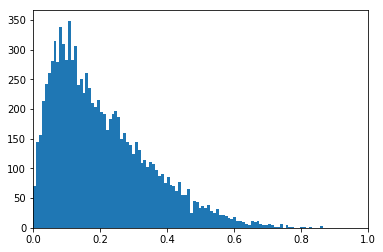

In [38]:
_ = plt.hist(e_beta[:,0,0], bins = 100)
plt.xlim(0,1)

(0, 1)

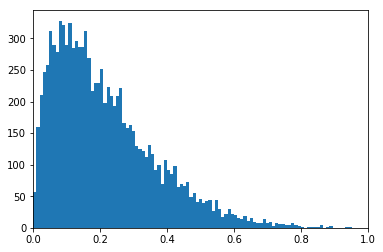

In [39]:
_ = plt.hist(e_beta[:,1,0], bins = 100)
plt.xlim(0,1)

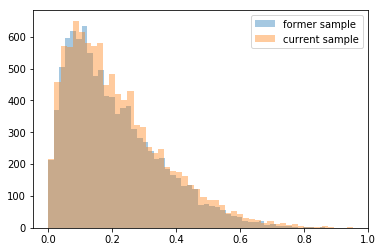

In [46]:
_ = plt.hist(e_beta[:,0,0], bins = 50, alpha = 0.4, label='former sample')
_ = plt.hist(e_beta[:,1,0], bins = 50, alpha = 0.4, label='current sample')

plt.legend()

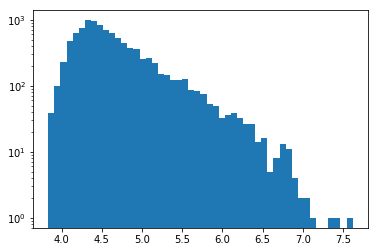

In [40]:
_ = plt.hist(np.log10(flux_in), bins = 50, log = True)

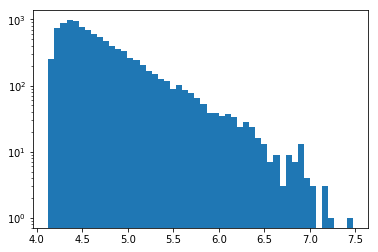

In [41]:
_ = plt.hist(np.log10(flux_out), bins = 50, log = True)

In [42]:
mag_former = -2.5*np.log10(flux_in)+38.4147
mag_now = -2.5*np.log10(flux_out)+38.4147

In [43]:
mag_former.shape

(10000,)

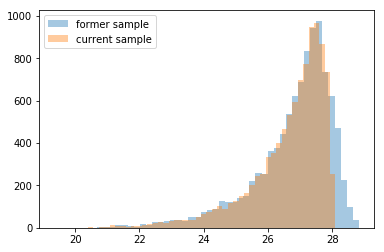

In [44]:
_ = plt.hist(mag_former, bins = 50, alpha = 0.4, label='former sample')
_ = plt.hist(mag_now, bins = 50, alpha = 0.4, label='current sample')

plt.legend()

In [45]:
np.max(mag_now)

28.10048569533257

In [54]:
input_noiseless = former[:,1]
output_vae = denorm(now[:,1], np.arange(10))

flux_in = []
flux_out = []
for j in range(10000):
    # Measurement of fluxes
    #mask = plot.createCircularMask(im_size,im_size,None,5)
    masked_img_in_simple = input_noiseless[j][r_band,:,:]
    #masked_img_in_simple[~mask] = 0  

    masked_img_out_simple = output_vae[j][r_band,:,:]
    #masked_img_out_simple[~mask] = 0

    # Calculate the luminosity by substracting the noise
    #flux_in[j,i] = np.sum(masked_img_in_simple)
    flux_in.append(np.sum(masked_img_in_simple))
    #flux_out[j,i] = np.sum(masked_img_out_simple)
    flux_out.append(np.sum(masked_img_out_simple))

    # Save scale radius and SNR
    #scale_radius.append(input_vae[2][i])
    #SNR.append(input_vae[3][i])

    #except :
    #    print('error for galaxy '+str(j*100))
    #    pass
    #continue

    #indices.append(input_vae[3])

flux_in_noisy = np.array(flux_in)#np.concatenate(flux_in)
flux_out_noisy = np.array(flux_out)#np.concatenate(flux_out)

In [55]:
np.max(flux_out_noisy)

29674813.31249913

/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.
/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


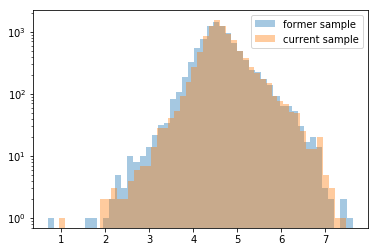

In [57]:
_ = plt.hist(np.log10(flux_in_noisy), bins = 50, log = True, alpha = 0.4, label='former sample')
_ = plt.hist(np.log10(flux_out_noisy), bins = 50, log = True, alpha = 0.4, label='current sample')

plt.legend()

In [80]:
former = np.load('/sps/lsst/users/barcelin/data/single/PSF_lsst_O.65/independant/galaxies_COSMOS_4_v5_test.npy', mmap_mode = 'c')
now = np.load('/sps/lsst/users/barcelin/data/single_galaxies/training/galaxies_isolated_20191022_2_images.npy', mmap_mode = 'c')

In [81]:
input_noiseless = norm(former[:,1], np.arange(10))
output_vae = now[:,1]# denorm(, np.arange(10))

flux_in = []
flux_out = []
for j in range(10000):
    # Measurement of fluxes
    masked_img_in_simple = input_noiseless[j][r_band,:,:]

    masked_img_out_simple = output_vae[j][r_band,:,:]
    #masked_img_out_simple[~mask] = 0

    # Calculate the luminosity by substracting the noise
    #flux_in[j,i] = np.sum(masked_img_in_simple)
    flux_in.append(np.ravel(masked_img_in_simple))
    #flux_out[j,i] = np.sum(masked_img_out_simple)
    flux_out.append(np.ravel(masked_img_out_simple))


flux_in_noisy = np.concatenate(np.array(flux_in))
flux_out_noisy = np.concatenate(np.array(flux_out))

In [82]:
np.min(flux_in_noisy), np.max(flux_in_noisy)

(-0.5597217903257479, 0.9999921669594374)

In [83]:
np.min(flux_out_noisy), np.max(flux_out_noisy)

(-0.5484843788683003, 0.9999948799538035)

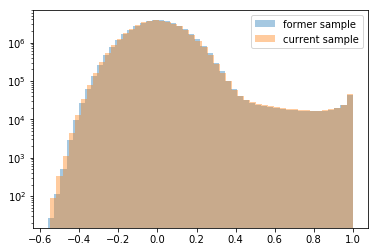

In [84]:
_ = plt.hist(flux_in_noisy, bins = 50, log = True, alpha = 0.4, label='former sample')
_ = plt.hist(flux_out_noisy, bins = 50, log = True, alpha = 0.4, label='current sample')

#plt.xlim(0, np.max(np.log10(flux_in_noisy)))
plt.legend()
#plt.xscale('log')